In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission_2.csv', 'sample_submission_1.csv', 'train_1.csv', 'key_2.csv', 'key_1.csv', 'train_2.csv']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

In [4]:
train = pd.read_csv('../input/train_1.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
def parse_page(page):
    x = page.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]

In [6]:
parse_page(train.Page[0])

('2NE1', 'zh.wikipedia.org', 'all-access', 'spider')

In [7]:
l = list(train.Page.apply(parse_page))
df = pd.DataFrame(l)
df.columns = ['Subject','Sub_Page','Access','Agent']
df.head()

,Subject,Sub_Page,Access,Agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52 Hz I Love You,zh.wikipedia.org,all-access,spider


In [8]:
train = pd.concat([train,df],axis=1)
del train['Page']

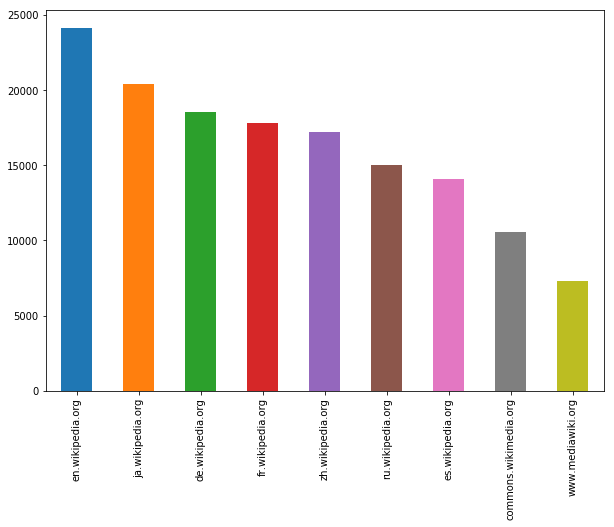

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Sub_Page.value_counts().plot(kind='bar')

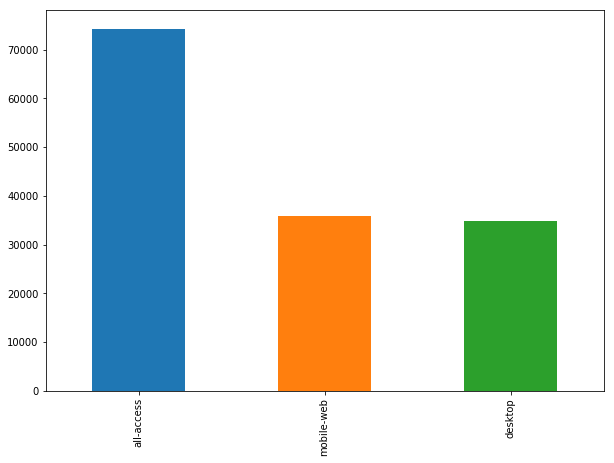

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Access.value_counts().plot(kind='bar')

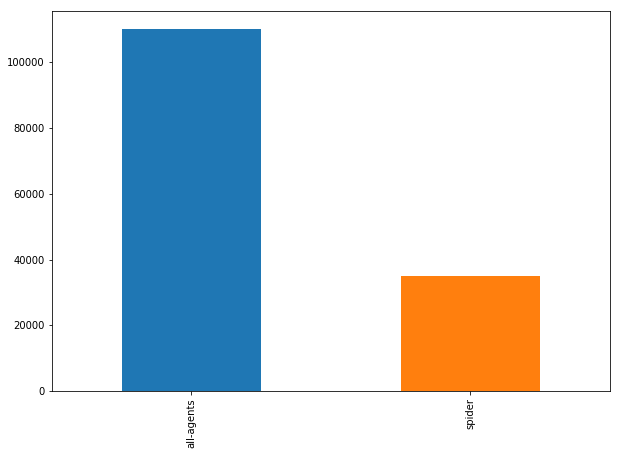

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
train.Agent.value_counts().plot(kind='bar')

In [12]:
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Subject,Sub_Page,Access,Agent
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh.wikipedia.org,all-access,spider
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh.wikipedia.org,all-access,spider
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh.wikipedia.org,all-access,spider
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh.wikipedia.org,all-access,spider
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,11.0,27.0,13.0,36.0,10.0,52 Hz I Love You,zh.wikipedia.org,all-access,spider


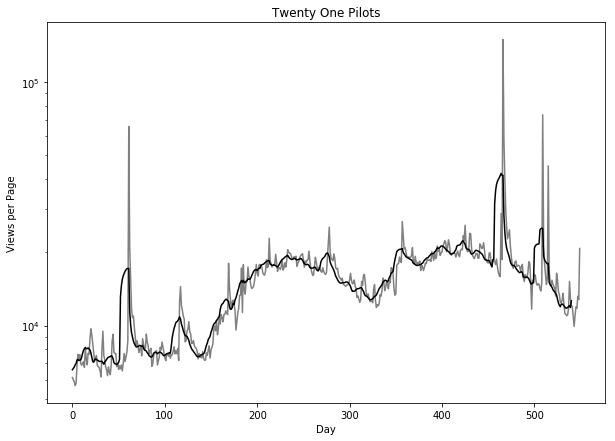

In [13]:
from matplotlib import dates

idx = 39457

window = 10


data = train.iloc[idx,0:-4]
name = train.iloc[idx,-4]
days = [r for r in range(data.shape[0] )]

fig, ax = plt.subplots(figsize=(10, 7))

plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title(name)

ax.plot(days,data.values,color='grey')
ax.plot(np.convolve(data, np.ones((window,))/window, mode='valid'),color='black')



ax.set_yscale('log')


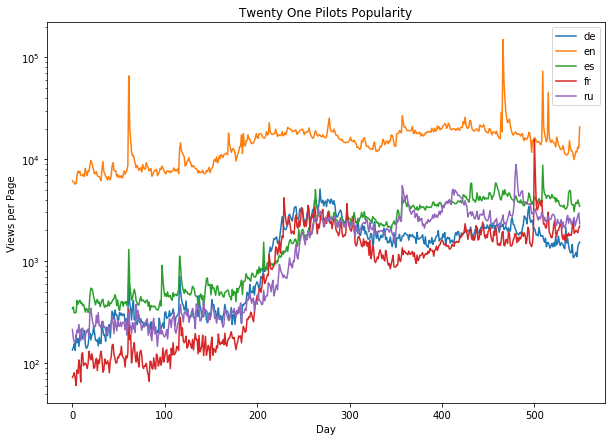

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Twenty One Pilots Popularity')
ax.set_yscale('log')
handles = []
for country in ['de','en','es','fr','ru']:
    idx= np.where((train['Subject'] == 'Twenty One Pilots') 
                  & (train['Sub_Page'] == '{}.wikipedia.org'.format(country)) 
                  & (train['Access'] == 'all-access') & (train['Agent'] == 'all-agents'))
    idx=idx[0][0]
    
    data = train.iloc[idx,0:-4]
    handle = ax.plot(days,data.values,label=country)
    handles.append(handle)

ax.legend()

In [15]:
from scipy.fftpack import fft

In [16]:
#idx = 39457
data = train.iloc[:,0:-4]
fft_complex = fft(data)

In [17]:
fft_complex.shape

(145063, 550)

In [18]:
fft_mag = [np.sqrt(np.real(x)*np.real(x)+
                   np.imag(x)*np.imag(x)) for x in fft_complex]


In [19]:
arr = np.array(fft_mag)

In [20]:
fft_mean = np.mean(arr,axis=0)

In [21]:
fft_mean.shape

(550,)

In [22]:
fft_xvals = [day / fft_mean.shape[0] for day in range(fft_mean.shape[0])]

In [23]:
npts = len(fft_xvals) // 2 + 1
fft_mean = fft_mean[:npts]
fft_xvals = fft_xvals[:npts]

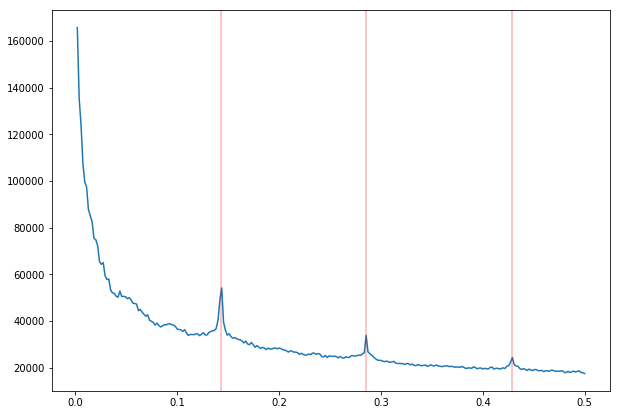

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fft_xvals[1:],fft_mean[1:])
plt.axvline(x=1./7,color='red',alpha=0.3)
plt.axvline(x=2./7,color='red',alpha=0.3)
plt.axvline(x=3./7,color='red',alpha=0.3)


In [25]:
from pandas.plotting import autocorrelation_plot

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_misc.py:557: RuntimeWarning: invalid value encountered in double_scalars
  (data[h:] - mean)).sum() / float(n) / c0


Text(0.5,1,'1K Autocorrelations')

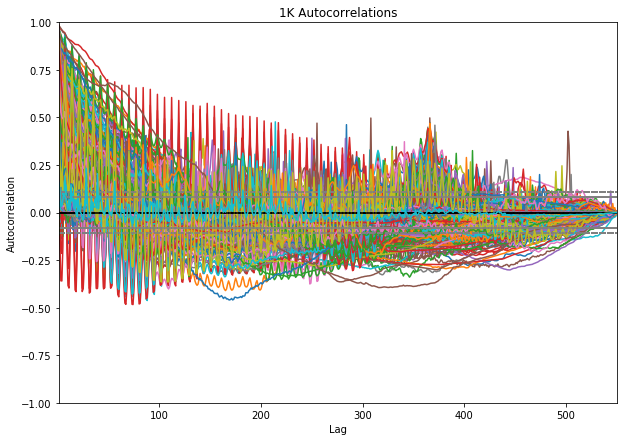

In [26]:

plt.figure(figsize=(10, 7))
a = np.random.choice(data.shape[0],1000)

for i in a:
    autocorrelation_plot(data.iloc[i])
    
plt.title('1K Autocorrelations')

Text(0.5,1,'Oh My Girl zh.wikipedia.org')

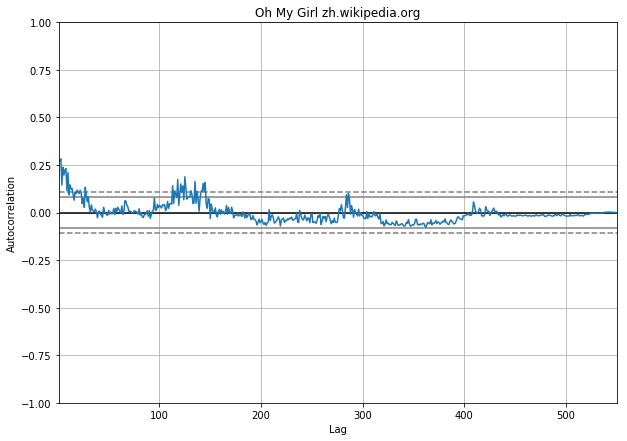

In [27]:
fig = plt.figure(figsize=(10, 7))

autocorrelation_plot(data.iloc[110])
plt.title(' '.join(train.loc[110,['Subject', 'Sub_Page']]))

In [28]:
data.shape

(145063, 550)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = data.iloc[:,:500]
y = data.iloc[:,500:]

In [31]:
X.shape

(145063, 500)

In [32]:
y.shape

(145063, 50)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, 
                                                  test_size=0.1, 
                                                  random_state=42)

In [34]:
def mape(y_true,y_pred):
    eps = 1
    err = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100
    return err

In [35]:
lookback = 50
lb_data = X_train[:,-lookback:]
med = np.median(lb_data,axis=1,keepdims=True)
eps = 1
err = mape(y_train,med)

In [36]:
err

68.1061532742806

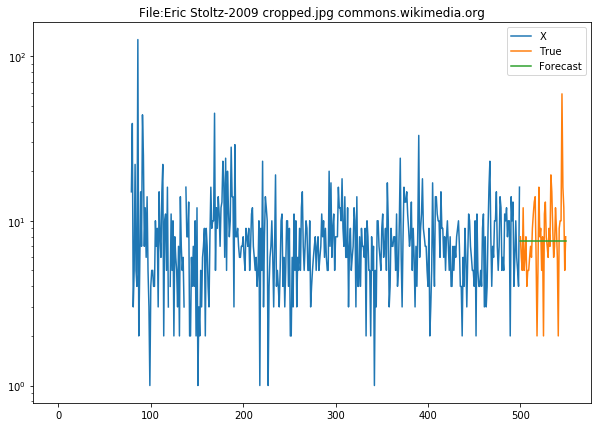

In [37]:
idx = 15000

fig, ax = plt.subplots(figsize=(10, 7))


ax.plot(np.arange(500),X_train[idx], label='X')
ax.plot(np.arange(500,550),y_train[idx],label='True')

ax.plot(np.arange(500,550),np.repeat(med[idx],50),label='Forecast')

plt.title(' '.join(train.loc[idx,['Subject', 'Sub_Page']]))
ax.legend()
ax.set_yscale('log')

In [38]:
from statsmodels.tsa.arima_model import ARIMA

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [39]:
model = ARIMA(X_train[0], order=(5,1,5))

In [40]:
model = model.fit()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
model.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  499
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3864.353
Method:                       css-mle   S.D. of innovations            554.901
Date:                Wed, 11 Apr 2018   AIC                           7752.705
Time:                        13:47:58   BIC                           7803.257
Sample:                             1   HQIC                          7772.543
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0502     15.544      0.196      0.845     -27.415      33.515
ar.L1.D.y     -0.0930      0.040     -2.335      0.020      -0.171      -0.015
ar.L2.D.y     -0.6624      0.033    -20.099      0.000      -0.727      -0.598
ar.L3.D.y     -0.5104      0.052     -9.780      0.000      -0.613      -0.408
ar.L4.D.y     -0.2225      0.032     -6.913      0.000      -0.286      -0.159
ar.L5.D.y     -0.8554      0.040    -21.494      0.000      -0.933      -0.777
ma.L1.D.y     -0.1237      0.052     -2.364      0.018      -0.226      -0.021
ma.L2.D.y      0.3654      0.044      8.278      0.000       0.279       0.452
ma.L3.D.y      0.4518      0.051      8.812      0.000       0.351       0.552
ma.L4.D.y     -0.2619      0.045     -5.789      0.000      -0.351      -0.173
ma.L5.D.y      0.6590      0.045     14.766      0.000       0.572       0.746
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6363           -0.7875j            1.0124           -0.1418
AR.2            0.6363           +0.7875j            1.0124            0.1418
AR.3           -1.0942           -0.0000j            1.0942           -0.5000
AR.4           -0.2192           -0.9971j            1.0210           -0.2844
AR.5           -0.2192           +0.9971j            1.0210            0.2844
MA.1           -1.0230           -0.0000j            1.0230           -0.5000
MA.2           -0.0932           -1.0750j            1.0790           -0.2638
MA.3           -0.0932           +1.0750j            1.0790            0.2638
MA.4            0.8034           -0.7927j            1.1287           -0.1239
MA.5            0.8034           +0.7927j            1.1287            0.1239
-----------------------------------------------------------------------------
"""

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'ARIMA residuals for 2NE1 pageviews')

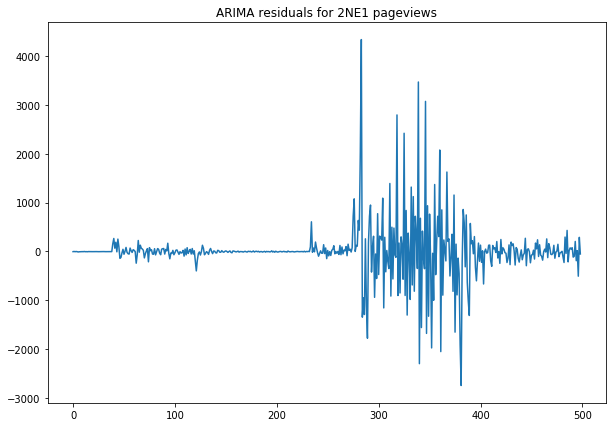

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))
idx = 0
residuals = pd.DataFrame(model.resid)
ax.plot(residuals)

plt.title('ARIMA residuals for 2NE1 pageviews')


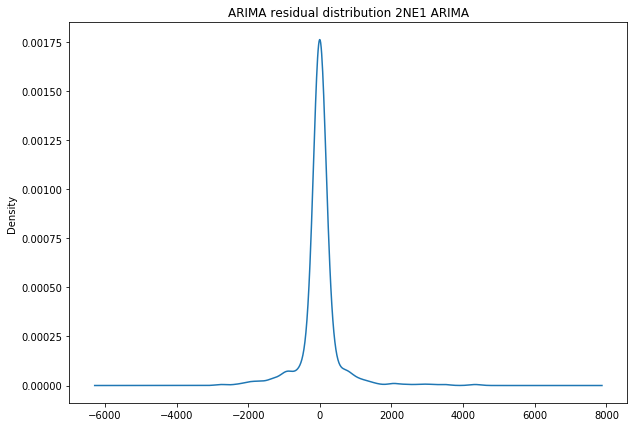

In [43]:
residuals.plot(kind='kde',
               figsize=(10,7),
               title='ARIMA residual distribution 2NE1 ARIMA', legend=False)

In [44]:
predictions, stderr, conf_int = model.forecast(50)

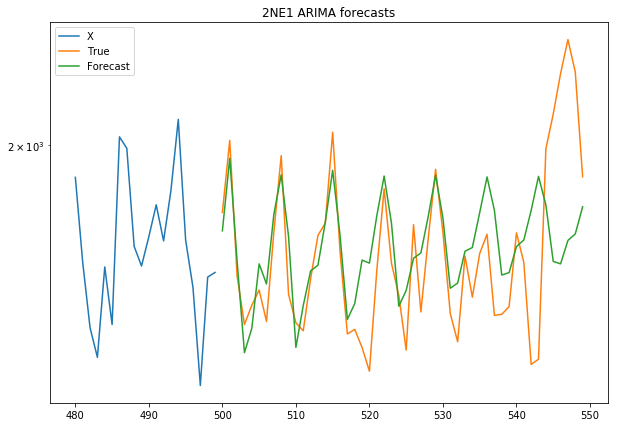

In [45]:
#target = y_train[0]
fig, ax = plt.subplots(figsize=(10, 7))


ax.plot(np.arange(480,500),X_train[0,480:], label='X')
ax.plot(np.arange(500,550),y_train[0],label='True')

ax.plot(np.arange(500,550),predictions,label='Forecast')


plt.title('2NE1 ARIMA forecasts')
ax.legend()
ax.set_yscale('log')

In [46]:
import simdkalman

In [47]:
smoothing_factor = 5.0

n_seasons = 7

# --- define state transition matrix A
state_transition = np.zeros((n_seasons+1, n_seasons+1))
# hidden level
state_transition[0,0] = 1
# season cycle
state_transition[1,1:-1] = [-1.0] * (n_seasons-1)
state_transition[2:,1:-1] = np.eye(n_seasons-1)

In [48]:
state_transition

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1., -1., -1., -1., -1., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [49]:
observation_model = [[1,1] + [0]*(n_seasons-1)]

In [50]:
observation_model

[[1, 1, 0, 0, 0, 0, 0, 0]]

In [51]:
level_noise = 0.2 / smoothing_factor
observation_noise = 0.2
season_noise = 1e-3

process_noise_cov = np.diag([level_noise, season_noise] + [0]*(n_seasons-1))**2
observation_noise_cov = observation_noise**2

In [52]:
process_noise_cov

array([[1.6e-03, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 1.0e-06, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00]])

In [53]:
observation_noise_cov

0.04000000000000001

In [54]:
kf = simdkalman.KalmanFilter(state_transition = state_transition,
                             process_noise = process_noise_cov,
                             observation_model = observation_model,
                             observation_noise = observation_noise_cov)

In [55]:
result = kf.compute(X_train[0], 50)

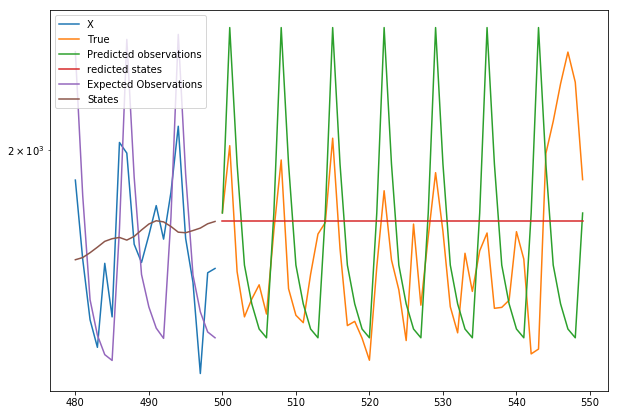

In [56]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(480,500),X_train[0,480:], label='X')
ax.plot(np.arange(500,550),y_train[0],label='True')

ax.plot(np.arange(500,550),
        result.predicted.observations.mean,
        label='Predicted observations')


ax.plot(np.arange(500,550),
        result.predicted.states.mean[:,0],
        label='redicted states')

ax.plot(np.arange(480,500),
        result.smoothed.observations.mean[480:],
        label='Expected Observations')

ax.plot(np.arange(480,500),
        result.smoothed.states.mean[480:,0],
        label='States')



ax.legend()
ax.set_yscale('log')